In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gdown

## Loading and cleaning

In [14]:
# Loading data from GDrive.

# Data with BDL merged,
file_id = "14VMCwHF2qoezvXykUvjfMNM1a573gQ8M"
url = f"https://drive.google.com/uc?id={file_id}"
file_extension = "downloaded_file.csv"
gdown.download(url, file_extension, quiet=False)
df = pd.read_csv(file_extension, sep=",")

Downloading...
From (original): https://drive.google.com/uc?id=14VMCwHF2qoezvXykUvjfMNM1a573gQ8M
From (redirected): https://drive.google.com/uc?id=14VMCwHF2qoezvXykUvjfMNM1a573gQ8M&confirm=t&uuid=dca5bae1-6bb6-483c-af38-329283113ac1
To: C:\Users\Konrad\Desktop\Magisterka\Kod\2024-mgr-sluzba-cywilna\Python\Code\downloaded_file.csv
100%|██████████| 511M/511M [00:07<00:00, 66.1MB/s] 
C:\Users\Konrad\AppData\Local\Temp\ipykernel_2512\2459605807.py:8: DtypeWarning: Columns (30) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_extension, sep=",")


In [15]:
# Changing "," to "." in numerical variables.
comma_cols_to_replace = {
    'mediana_wieku': 'bdl_age_median',
    'wydatki_powiat': 'bdl_district_expenses',
    'wynagrodzenia': 'bdl_average_salary'
}

# Replace commas with dots and convert to float.
for old_col, new_col in comma_cols_to_replace.items():
    df[new_col] = df[old_col].str.replace(',', '.', regex=False).astype(float)

df.drop(columns=comma_cols_to_replace.keys(), inplace=True)

In [16]:
# Other columns to rename.
col_names_to_replace = {
    'cena_mieszkan': 'bdl_avg_house_pricing',
    'saldo_migracji': 'bdl_migration_coefficient',
    'wsp_feminizacji': 'bdl_feminization_coefficient'
}

for old_col, new_col in col_names_to_replace.items():
    df[new_col] = df[old_col].astype(float)
    df.drop([old_col], axis=1, inplace=True)

## Feature engineering

In [17]:
df['filled_vacancies_per_all'] = df['result'] / df['vacancies']

In [18]:
df.head()

,Unnamed: 0,ad_id,result,job_field,position_category,position,education_level,work_time,vacancies,city,...,employment_contract,voivodeship,district,bdl_age_median,bdl_district_expenses,bdl_average_salary,bdl_avg_house_pricing,bdl_migration_coefficient,bdl_feminization_coefficient,filled_vacancies_per_all
0,0,130994,1,vet,stanowiska samodzielne,inspektor weterynaryjny,3,0.5,1,Olesno,...,1.19,16,8,44.8,1592.76,6255.53,4196.0,-160.0,106.0,1.0
1,0,130994,1,vet,stanowiska samodzielne,inspektor weterynaryjny,3,0.5,1,Olesno,...,1.19,16,8,44.8,1592.76,82.40,4196.0,-160.0,106.0,1.0
2,1,130970,0,tech/construction,stanowiska samodzielne,starszy specjalista,3,1.0,1,Bydgoszcz,...,0.50,4,61,44.9,NaN,7478.19,7213.0,-828.0,114.0,0.0
3,1,130970,0,tech/construction,stanowiska samodzielne,starszy specjalista,3,1.0,1,Bydgoszcz,...,0.50,4,61,44.9,NaN,98.50,7213.0,-828.0,114.0,0.0
4,2,130898,1,vet,stanowiska samodzielne,asystent,2,1.0,1,Chrzanów,...,NaN,12,3,45.3,1483.72,6898.73,5217.0,-196.0,107.0,1.0


In [19]:
df['offer_salary'].replace("nie podano wynagrodzenia", np.nan, inplace=True)
df['offer_salary_mentioned'] = df['offer_salary'].notna().astype(int)

C:\Users\Konrad\AppData\Local\Temp\ipykernel_2512\3304667184.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['offer_salary'].replace("nie podano wynagrodzenia", np.nan, inplace=True)


In [20]:
# Variable correlation
numerical_columns_df = df[[
    'work_time',
    'ad_views',
    'year',
    'advertised_institution',
    'applicants',
    'education_level',
    'salary_for_position',
    'women_percentage',
    'bdl_feminization_coefficient',
    'fluctuation',
    'employment_contract',
    'bdl_avg_house_pricing',
    'bdl_age_median',
    'bdl_migration_coefficient',
    'bdl_district_expenses',
    'bdl_average_salary',
    'education_level',
    'offer_salary_mentioned',
    'vacancies',
    'result'
]]


correlation = numerical_columns_df.corr()['result']

# Display the correlation matrix
print(correlation)

work_time                      -0.006045
ad_views                        0.228746
year                           -0.082010
advertised_institution          0.165031
applicants                      0.328321
education_level                -0.171731
salary_for_position             0.011918
women_percentage                0.025791
bdl_feminization_coefficient   -0.011355
fluctuation                    -0.065407
employment_contract             0.156612
bdl_avg_house_pricing          -0.090104
bdl_age_median                  0.020876
bdl_migration_coefficient      -0.056334
bdl_district_expenses          -0.080232
bdl_average_salary             -0.022229
education_level                -0.171731
offer_salary_mentioned          0.056738
vacancies                       0.067366
result                          1.000000
Name: result, dtype: float64


In [21]:
# Dropping cols unnecessary for statistical analyses.
string_cols_for_temporary_dropping = [
    'ad_id',
    'institution',
    'institution_address',
    'workplace',
    'department',
    'job_field',
    'position_category',
    'responsibilities',
    'requirements',
    'offer_salary',
    'Unnamed: 0',
    'date_announced',
    'nice_to_have',
    'institution_address',
    'advertised_institution',
    'workplace',
    'department',
    'city',
    'position'
]
df_numerical = df.drop(string_cols_for_temporary_dropping, axis=1)

In [22]:
# Aggregating data to district-level.
df_numerical_district_level = df_numerical.groupby(['district', 'voivodeship', 'year']).agg('mean').reset_index()
df_numerical_district_level.head(100)

,district,voivodeship,year,result,education_level,work_time,vacancies,ad_views,applicants,salary_for_position,...,fluctuation,employment_contract,bdl_age_median,bdl_district_expenses,bdl_average_salary,bdl_avg_house_pricing,bdl_migration_coefficient,bdl_feminization_coefficient,filled_vacancies_per_all,offer_salary_mentioned
0,1,2,2017,1.000000,2.000000,1.000000,1.000000,2757.333333,NaN,NaN,...,NaN,NaN,NaN,990.41,1994.070,2824.0,14.0,106.0,1.000000,0.000000
1,1,2,2018,0.750000,2.333333,1.000000,1.000000,2579.416667,10.080777,4795.236285,...,0.110491,213.601818,41.1,1137.92,2150.930,2818.0,35.0,106.0,0.750000,0.000000
2,1,2,2019,0.750000,2.083333,1.000000,1.000000,2503.916667,4.353977,5809.787882,...,0.061550,123.644000,41.5,1091.65,2316.520,3566.0,-8.0,106.0,0.750000,0.000000
3,1,2,2020,0.909091,2.090909,1.000000,1.000000,2258.363636,12.497335,6553.158228,...,0.039564,547.950000,42.1,1248.52,2488.225,4188.0,-20.0,106.0,0.909091,0.363636
4,1,2,2021,0.800000,1.700000,1.000000,1.100000,1729.200000,11.856658,7567.932681,...,0.205618,501.230000,42.4,1290.95,2776.470,4467.0,53.0,106.0,0.750000,0.900000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1,30,2021,0.260870,2.826087,1.000000,1.043478,1192.478261,1.951240,8760.003145,...,0.105135,164.449565,NaN,NaN,NaN,NaN,NaN,NaN,0.239130,0.130435
96,1,30,2022,0.272727,2.772727,0.965909,1.000000,1031.227273,1.318415,8933.136854,...,0.008238,20.625909,NaN,NaN,NaN,NaN,NaN,NaN,0.272727,0.000000
97,1,30,2023,0.777778,2.222222,1.000000,1.000000,991.666667,7.697741,10036.946215,...,0.092165,411.698750,NaN,NaN,NaN,NaN,NaN,NaN,0.777778,0.333333
98,1,32,2017,1.000000,1.000000,1.000000,1.000000,2631.000000,NaN,NaN,...,NaN,NaN,NaN,1162.28,1919.850,2037.0,-93.0,104.0,1.000000,0.000000


## Analyses

In [23]:
df_numerical_district_level.describe()

,district,voivodeship,year,result,education_level,work_time,vacancies,ad_views,applicants,salary_for_position,...,fluctuation,employment_contract,bdl_age_median,bdl_district_expenses,bdl_average_salary,bdl_avg_house_pricing,bdl_migration_coefficient,bdl_feminization_coefficient,filled_vacancies_per_all,offer_salary_mentioned
count,2289.000000,2289.000000,2289.000000,2289.000000,2289.000000,2289.000000,2289.000000,2289.000000,2041.000000,1913.000000,...,2041.000000,2014.000000,1915.000000,1681.000000,2132.000000,2132.000000,2132.000000,2132.000000,2289.000000,2289.000000
mean,21.813019,17.079948,2020.142420,0.667927,2.346084,0.973049,1.062953,2002.692583,8.674201,7933.005074,...,0.100878,425.666158,42.117911,1467.492035,2572.091782,4179.433396,-19.327861,105.340525,0.648479,0.214949
std,22.339971,9.438482,1.934411,0.252144,0.413602,0.063680,0.143871,717.989785,6.201036,1592.781571,...,0.085464,425.131318,2.018495,449.760306,553.255849,1636.431499,670.914837,4.052030,0.249381,0.288743
min,1.000000,2.000000,2017.000000,0.000000,1.000000,0.250000,1.000000,517.250000,0.000000,3912.837838,...,0.000000,0.060000,34.600000,604.590000,0.000000,0.000000,-1065.000000,96.000000,0.000000,0.000000
25%,6.000000,10.000000,2018.000000,0.500000,2.000000,0.970588,1.000000,1304.461538,4.014572,6741.946381,...,0.047543,124.192155,40.700000,1146.540000,2147.975000,3078.750000,-205.000000,102.000000,0.496032,0.000000
50%,13.000000,18.000000,2020.000000,0.673913,2.375000,1.000000,1.000000,2261.300000,7.368333,7787.594585,...,0.083548,289.052000,42.100000,1380.220000,2479.962500,3917.000000,-125.500000,104.000000,0.660714,0.036765
75%,25.000000,24.000000,2022.000000,0.875000,2.615385,1.000000,1.080000,2552.666667,11.628963,8939.384356,...,0.123565,584.371477,43.500000,1683.610000,2928.171250,4955.250000,-48.750000,107.250000,0.845771,0.375000
max,79.000000,32.000000,2023.000000,1.000000,4.000000,1.428571,3.666667,5436.000000,35.961697,15683.333333,...,0.989739,2294.290000,48.200000,5150.180000,6486.315000,15717.000000,11727.000000,119.000000,1.000000,1.000000


In [24]:
df.describe()

,Unnamed: 0,ad_id,result,education_level,work_time,vacancies,ad_views,year,advertised_institution,applicants,...,voivodeship,district,bdl_age_median,bdl_district_expenses,bdl_average_salary,bdl_avg_house_pricing,bdl_migration_coefficient,bdl_feminization_coefficient,filled_vacancies_per_all,offer_salary_mentioned
count,199681.000000,199681.000000,199681.000000,199681.000000,199663.000000,199681.000000,199675.000000,199681.000000,97928.000000,141341.000000,...,199681.000000,199681.000000,194324.000000,42370.000000,197478.000000,197478.000000,197478.000000,197478.000000,199681.000000,199681.000000
mean,50453.615372,74304.003325,0.583220,2.709952,0.984256,1.117227,2080.739271,2020.450629,0.829130,8.178100,...,16.050501,51.983724,41.945101,1478.575826,3252.731982,7123.193662,2835.358278,112.395244,0.551191,0.266185
std,29162.603673,32151.453040,0.493027,0.906552,0.099563,0.457323,845.779759,1.778654,0.376398,7.960640,...,8.072519,22.198569,1.776236,412.852977,3321.562979,2928.974205,4015.736863,5.156581,0.483583,0.441963
min,0.000000,15556.000000,0.000000,1.000000,0.000000,1.000000,124.000000,2017.000000,0.000000,0.000000,...,2.000000,1.000000,34.600000,604.590000,0.000000,0.000000,-1065.000000,96.000000,0.000000,0.000000
25%,25180.000000,46521.000000,0.000000,2.000000,1.000000,1.000000,1347.000000,2019.000000,1.000000,2.666667,...,12.000000,61.000000,40.700000,1179.840000,108.500000,4747.000000,-167.000000,110.000000,0.000000,0.000000
50%,50442.000000,74536.000000,1.000000,3.000000,1.000000,1.000000,2173.000000,2021.000000,1.000000,5.972662,...,14.000000,62.000000,41.500000,1404.700000,169.400000,6656.000000,209.000000,114.000000,1.000000,0.000000
75%,75734.000000,102177.000000,1.000000,3.000000,1.000000,1.000000,2632.000000,2022.000000,1.000000,10.666667,...,22.000000,65.000000,43.300000,1682.660000,6432.780000,9129.000000,6224.000000,117.000000,1.000000,1.000000
max,100941.000000,130994.000000,1.000000,4.000000,5.000000,5.000000,11911.000000,2023.000000,1.000000,116.000000,...,32.000000,79.000000,48.200000,5150.180000,12804.030000,15717.000000,11727.000000,119.000000,1.000000,1.000000


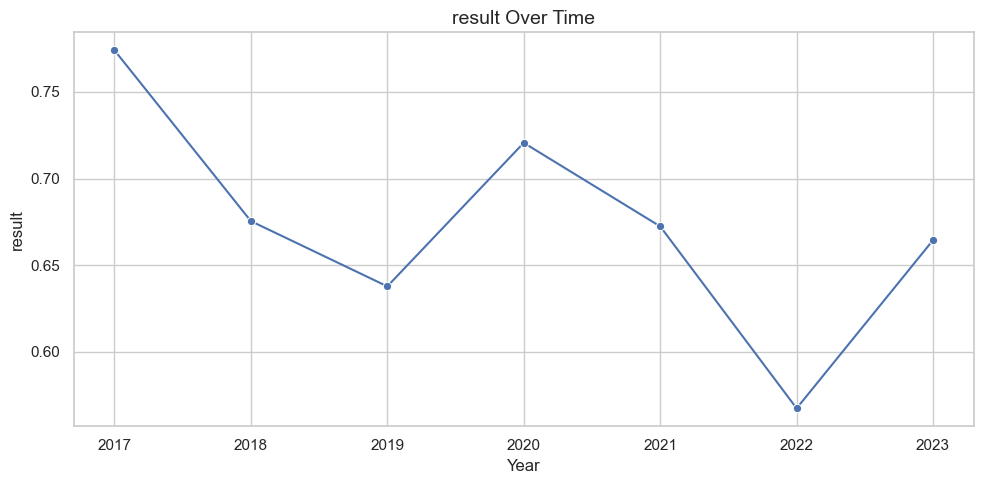

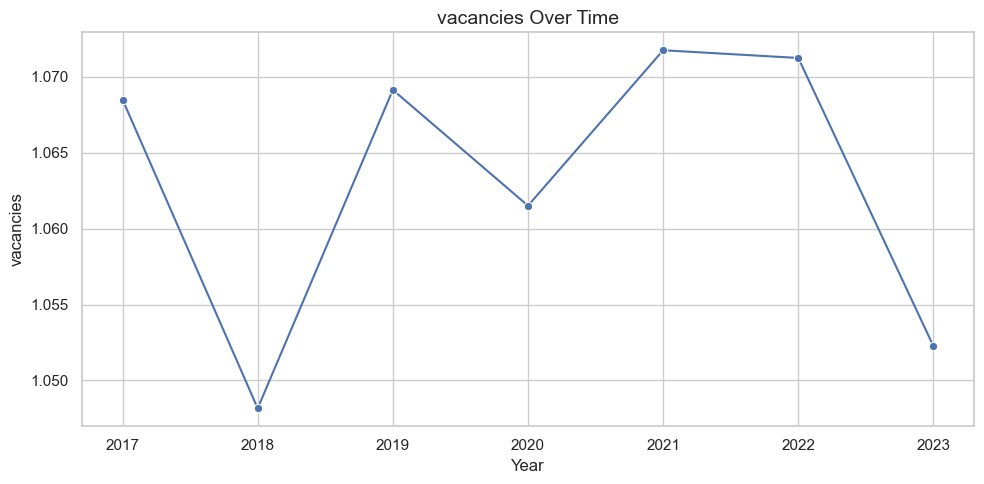

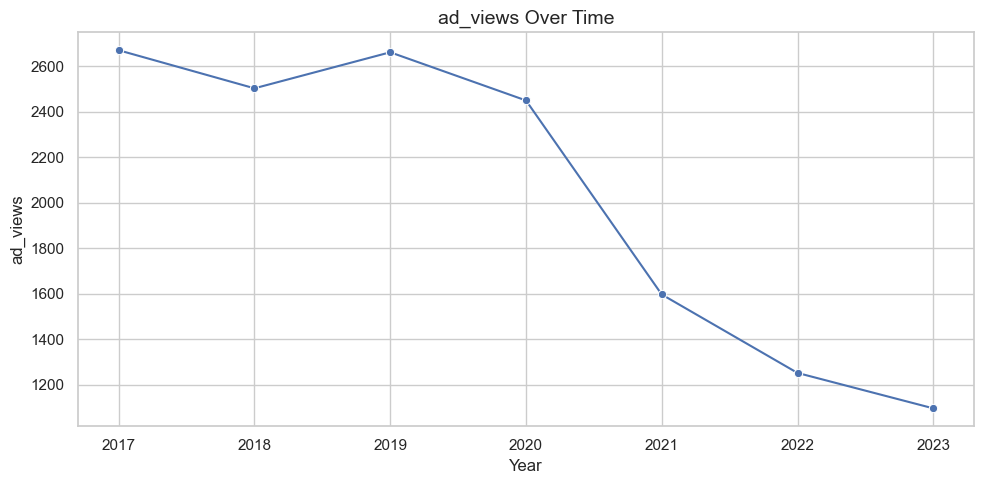

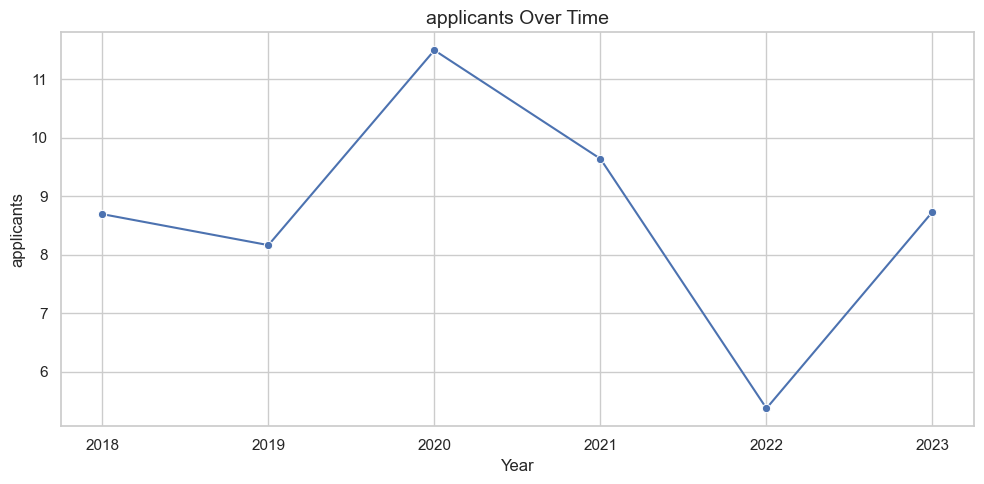

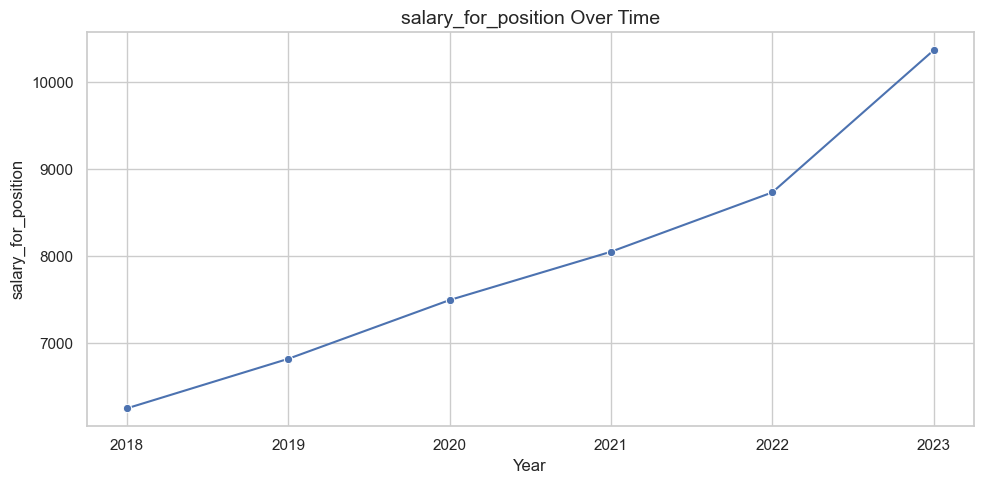

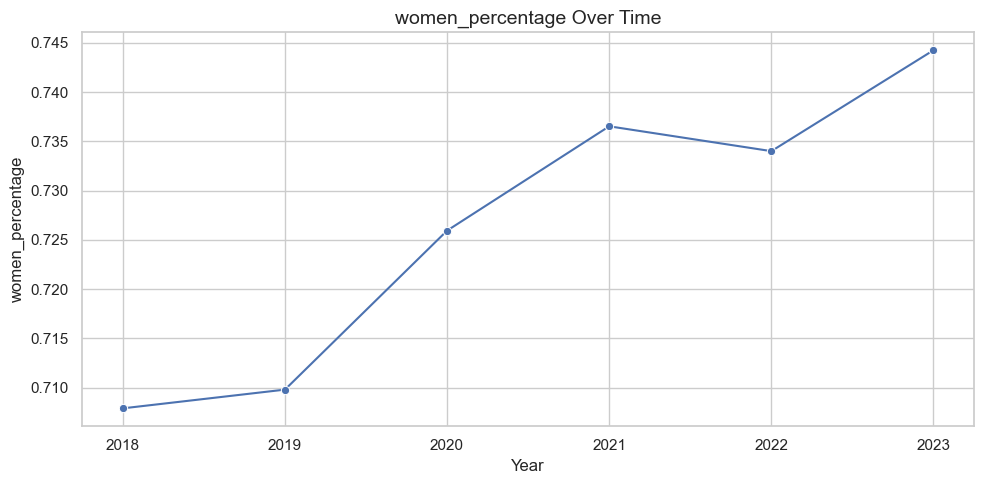

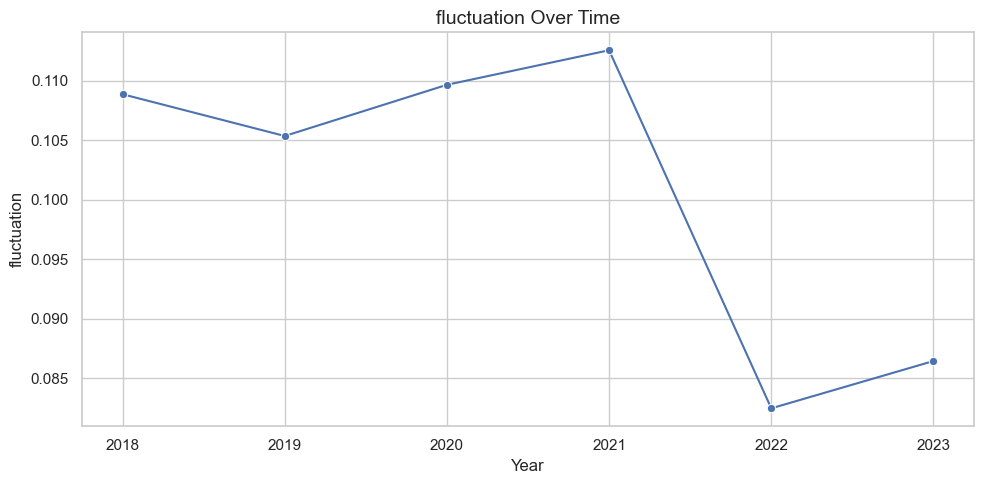

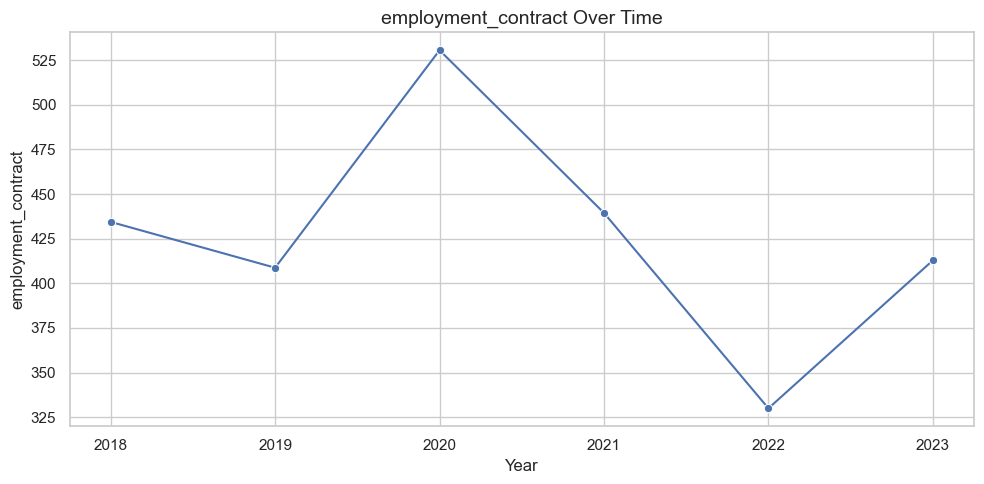

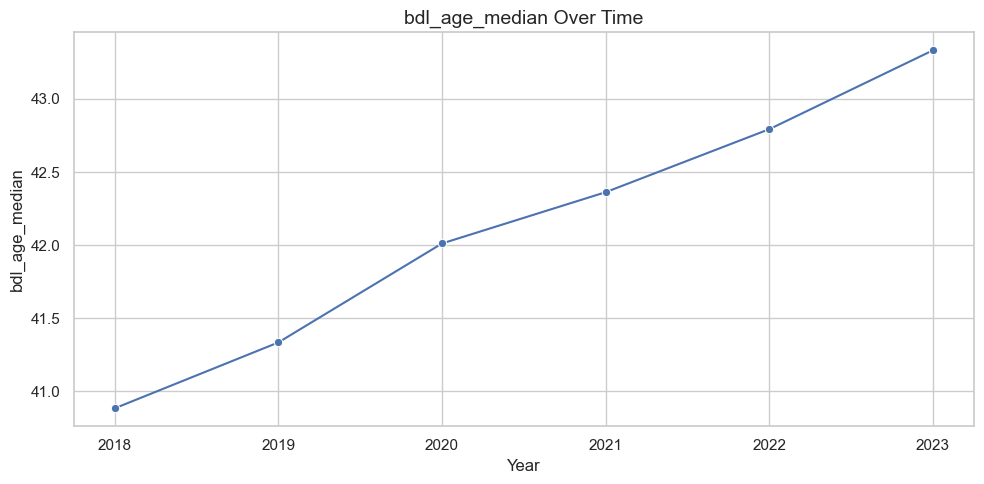

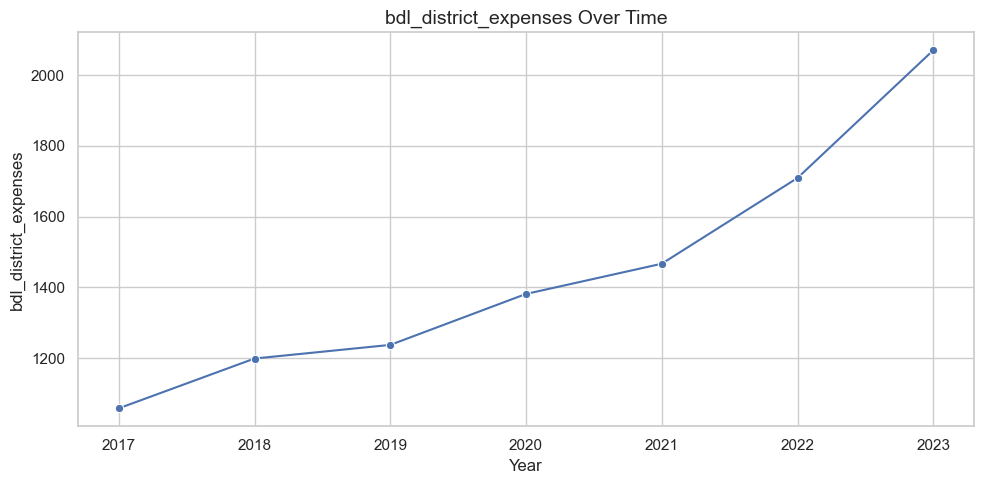

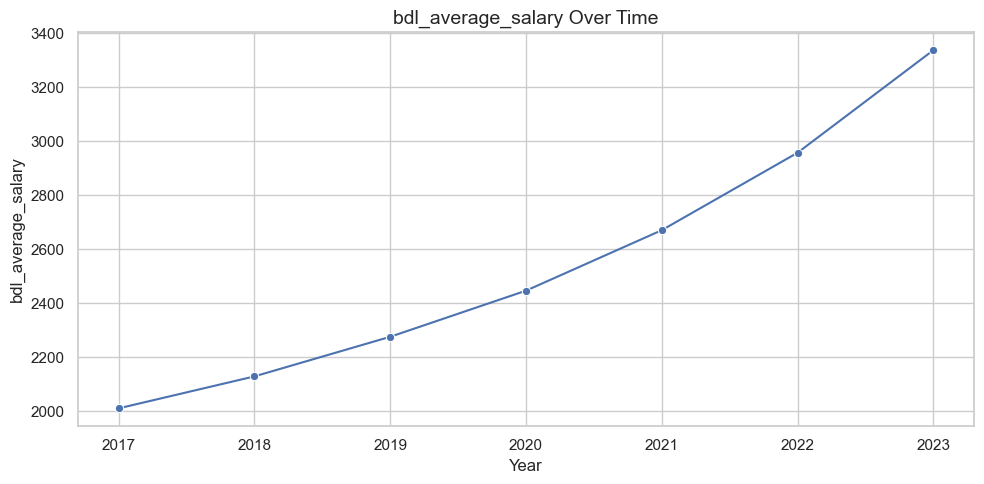

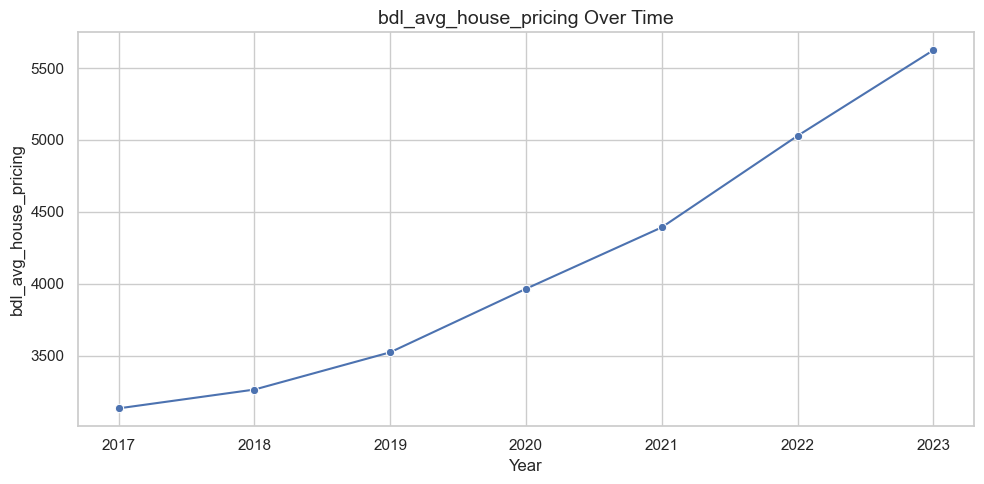

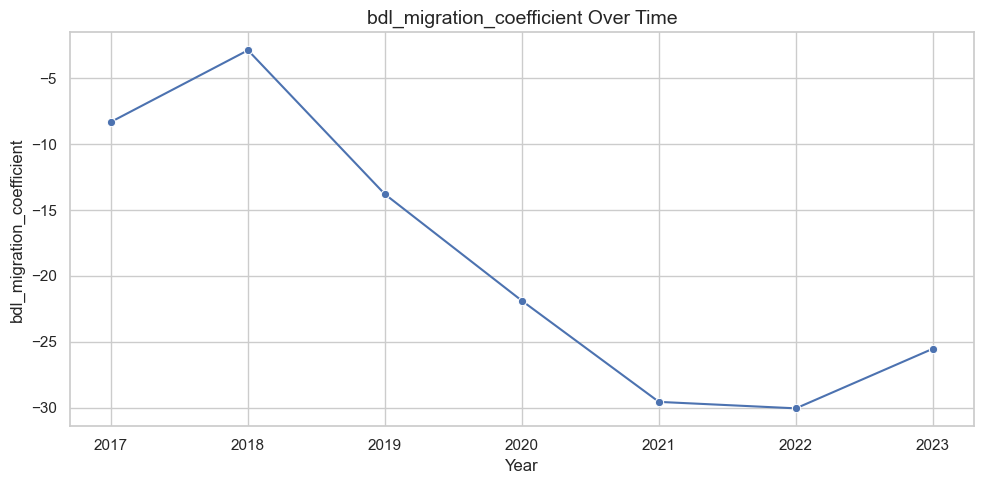

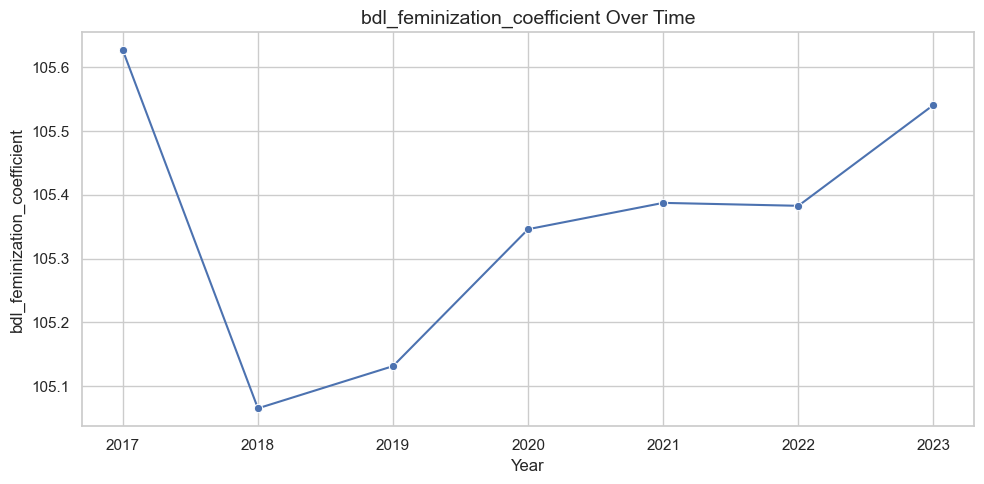

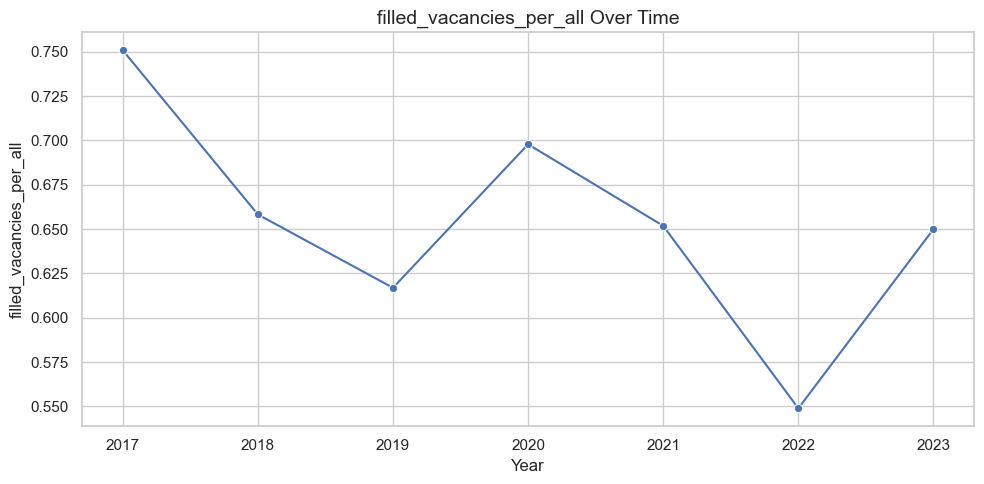

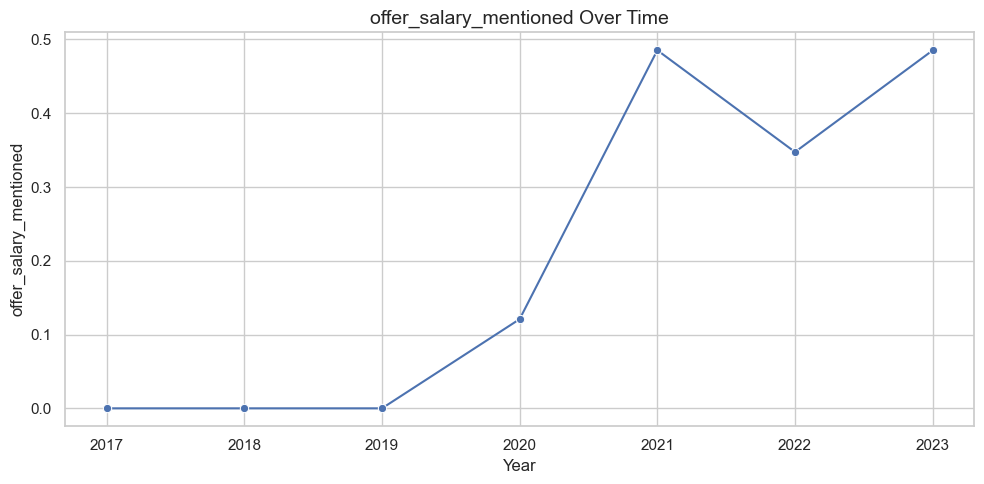

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_individual_time_series(dataframe):
    # Columns to exclude from plotting
    exclude_columns = ['voivodeship', 'district', 'education_level', 'work_time']

    # Group by year and compute mean for numeric columns only.
    df_grouped = dataframe.groupby('year').mean(numeric_only=True)

    # Drop the excluded columns (if they exist).
    columns_to_plot = [col for col in df_grouped.columns if col not in exclude_columns]

    # Plot each column individually
    for column in columns_to_plot:
        plt.figure(figsize=(10, 5))
        sns.lineplot(x=df_grouped.index, y=df_grouped[column], marker='o')
        plt.title(f"{column} Over Time", fontsize=14)
        plt.xlabel("Year")
        plt.ylabel(column)
        plt.grid(True)
        plt.tight_layout()
        plt.show()

plot_individual_time_series(df_numerical_district_level)